<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

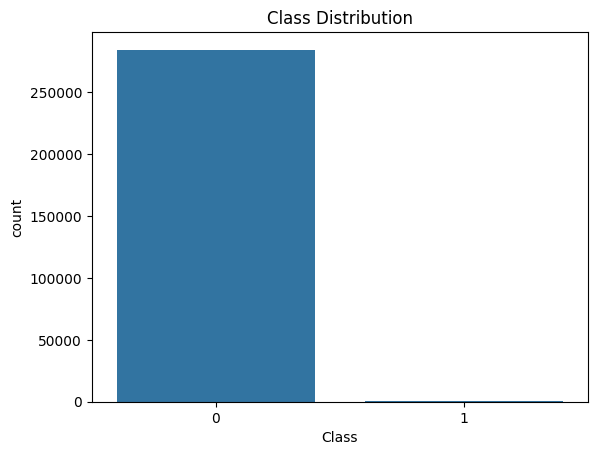

Обнаружено аномалий (Z-оценка): 26232
Isolation Forest Results:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85307
           1       0.10      0.62      0.17       136

    accuracy                           0.99     85443
   macro avg       0.55      0.81      0.58     85443
weighted avg       1.00      0.99      0.99     85443



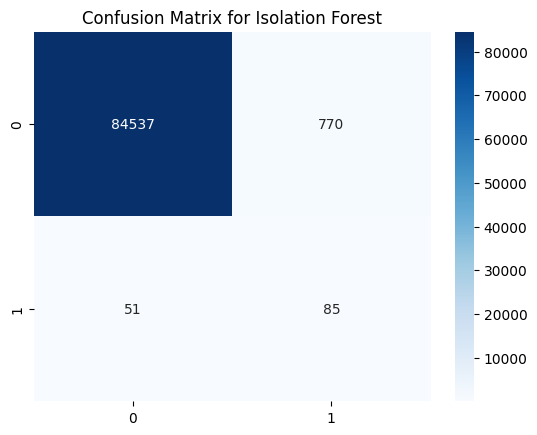

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

data = pd.read_csv('/Users/macbookair/Desktop/data_mining2/creditcard.csv')
print(data.info())
print(data.describe())

sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.show()

X = data.drop(columns=['Class'])
y = data['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

z_scores = np.abs(X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
outliers_z = (z_scores > 3).any(axis=1)
print(f"Обнаружено аномалий (Z-оценка): {np.sum(outliers_z)}")

iso_forest = IsolationForest(contamination=0.01, random_state=42)
y_pred_iso = iso_forest.fit_predict(X_test)
y_pred_iso = [1 if pred == -1 else 0 for pred in y_pred_iso]  
print("Isolation Forest Results:")
print(classification_report(y_test, y_pred_iso))
conf_matrix_iso = confusion_matrix(y_test, y_pred_iso)
sns.heatmap(conf_matrix_iso, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Isolation Forest")
plt.show()

oc_svm = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)
oc_svm.fit(X_train)
y_pred_svm = oc_svm.predict(X_test)
y_pred_svm = [1 if pred == -1 else 0 for pred in y_pred_svm] 
print("One-Class SVM Results:")
print(classification_report(y_test, y_pred_svm))
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for One-Class SVM")
plt.show()

input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(14, activation="relu")(input_layer)
encoder = Dense(7, activation="relu")(encoder)
encoder = Dense(3, activation="relu")(encoder)
decoder = Dense(7, activation="relu")(encoder)
decoder = Dense(14, activation="relu")(decoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)
y_pred_auto = [1 if e > threshold else 0 for e in mse]

print("Autoencoder Results:")
print(classification_report(y_test, y_pred_auto))
conf_matrix_auto = confusion_matrix(y_test, y_pred_auto)
sns.heatmap(conf_matrix_auto, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Autoencoder")
plt.show()

plt.figure(figsize=(10, 8))
for y_pred, label in zip([y_pred_iso, y_pred_svm, y_pred_auto], ["Isolation Forest", "One-Class SVM", "Autoencoder"]):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

